# Species Distribution Model (SDM)

We are creating a species distribution model (SDM) for litoria fallax across Australia using weather data from the TerraClimate dataset.

<center>
<img src="pictures/Litoria_fallax.jpg" width="500" height="340"> 


| Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
| Australia                     | Coarse (4km)  | 1 species  | TerraClimate    

</center>

SDM is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

Frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. 


In [5]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
from itertools import cycle
import glob

In [6]:
Australia_frogs = pd.read_csv('Australia_frogs.csv').drop('Unnamed: 0',axis=1)
Australia_frogs.head()

,gbifID,basisOfRecord,eventDate,stateProvince,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,species,country,continent,year,month,Litoria_fallax_status
0,1944370584,Human_Observation,2018-04-18 19:05:00,New South Wales,-33.693144,151.320884,28930.0,Litoria Fallax,Australia,Australia,2018.0,4.0,1
1,1500319380,Human_Observation,2009-07-28 17:16:00,Queensland,-27.888019,153.309342,20674.0,Litoria Fallax,Australia,Australia,2009.0,7.0,1
2,2423011701,Human_Observation,2019-08-28 09:24:00,New South Wales,-33.925746,151.164082,4.0,Litoria Fallax,Australia,Australia,2019.0,8.0,1
3,2236299662,Human_Observation,2018-02-13 23:02:00,New South Wales,-31.732415,152.088515,29199.0,Litoria Fallax,Australia,Australia,2018.0,2.0,1
4,2456512415,Human_Observation,2016-04-17 11:12:00,Queensland,-27.476426,152.977687,278.0,Litoria Fallax,Australia,Australia,2016.0,4.0,1


In [7]:
target_species = 'Litoria Fallax'
target_species_frog_data = Australia_frogs[Australia_frogs['Litoria_fallax_status'] == 1]
frog_data = (
    Australia_frogs
    [lambda x: x['Litoria_fallax_status'] == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)

In [8]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])

    # Select datapoints that overlap region
   
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=time_slice)
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

In [9]:
def plotterraclimatevar (data,State, Decade):
    nrow = 2
    ncol = 3
    fig, ax = plt.subplots(nrow, ncol, figsize=(12, 8), sharex=True, sharey=True)
    bands = data.band.values
    filt = frog_data['Litoria_fallax_status'] == 1
    cmaps = ["Blues", "BrBG", "Blues",  "cool", "cool", "BrBG"]

    for i in range(len(bands)):
        xr.plot.imshow(data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
        ax[i//ncol, i%ncol].set_title(bands[i])
        ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
                                    color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

    fig.suptitle(f'Spatial distribution of Terraclimate variables {State} in {Decade}', fontsize=20)
    fig.legend(loc=(0.85, 0.933))


In [10]:
def plotterraclimatedistribution (data,State, Decade):
    row = 2
    ncol = 3
    fig, ax = plt.subplots(row, ncol, figsize=(13, 7))
    bands = data.band.values

    for i in range(len(bands)):
        xr.plot.hist(data[i], ax=ax[i//ncol, i%ncol])

    fig.suptitle(f'Frequency distribution of TerraClimate variables  {State} in {Decade}',  fontsize=20)

In [11]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )

In [12]:
# Metrics to measure over time dimension
tc_metrics = {'mean': {'fn':np.nanmean, 'params':{}},
              'min': {'fn':np.nanmin, 'params':{}},
              'max': {'fn':np.nanmax, 'params':{}}}

# Measurements to take
assets=['aet','ppt','soil','tmax', 'tmin', 'vap']

# Features to take, in form '<asset>_<metric>'
features=['aet_mean','ppt_mean','soil_mean','tmax_mean', 'tmin_mean', 'vap_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

In [13]:
for state in frog_data['stateProvince'].unique():
    frog_state_data = frog_data[frog_data['stateProvince']== state]
    min_lon = frog_state_data['decimalLongitude'].min()
    min_lat = frog_state_data['decimalLatitude'].min()
    max_lon = frog_state_data['decimalLongitude'].max()
    max_lat = frog_state_data['decimalLatitude'].max()
    bbox = (min_lon, min_lat, max_lon, max_lat)
    
    statedata = pd.DataFrame()
    for decade in [('1990-01-01','1999-12-31'),('2000-01-01','2009-12-31'),('2010-01-01','2019-12-31')]:
        time_min = decade[0]
        time_max = decade[1]
        time_slice = slice(time_min,time_max)

        weather_decadestate = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
        plotterraclimatevar (weather_decadestate,state, decade)
        plotterraclimatedistribution (weather_decadestate,state, decade)
        statedecadeata = join_frogs(frog_state_data,weather_decadestate)
        statedata = statedata.append(statedecadeata)
    
    statedata.to_csv(f'FrogsWeatherStates Data/{state}.csv')

SSL error in data received
protocol: <asyncio.sslproto.SSLProtocol object at 0x000001BCDB02BB20>
transport: <_SelectorSocketTransport fd=5344 read=polling write=<idle, bufsize=0>>
Traceback (most recent call last):
  File "C:\Users\forqu\anaconda\lib\asyncio\sslproto.py", line 529, in data_received
    ssldata, appdata = self._sslpipe.feed_ssldata(data)
  File "C:\Users\forqu\anaconda\lib\asyncio\sslproto.py", line 200, in feed_ssldata
    chunk = self._sslobj.read(self.max_size)
  File "C:\Users\forqu\anaconda\lib\ssl.py", line 888, in read
    v = self._sslobj.read(len)
MemoryError


MemoryError: Unable to allocate 94.9 MiB for an array with shape (12, 1440, 1440) and data type float32

In [ ]:
import glob
Australia_frogweather = pd.concat(map(pd.read_csv, glob.glob('FrogsWeatherStates Data/*.csv'))).drop('Unnamed: 0', axis=1).dropna()
Australia_frogweather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266202 entries, 0 to 9722
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   gbifID                         266202 non-null  int64  
 1   basisOfRecord                  266202 non-null  object 
 2   eventDate                      266202 non-null  object 
 3   stateProvince                  266202 non-null  object 
 4   decimalLatitude                266202 non-null  float64
 5   decimalLongitude               266202 non-null  float64
 6   coordinateUncertaintyInMeters  266202 non-null  float64
 7   species                        266202 non-null  object 
 8   country                        266202 non-null  object 
 9   continent                      266202 non-null  object 
 10  year                           266202 non-null  float64
 11  month                          266202 non-null  float64
 12  Species_status                 2

In [ ]:
Australia_frogweather['basisOfRecord'].value_counts()

Human_Observation      256545
Occurrence               6609
Preserved_Specimen       1974
Observation               648
Machine_Observation       354
Material_Sample            72
Name: basisOfRecord, dtype: int64

In [ ]:
dummies_basisOfRecord = pd.get_dummies(Australia_frogweather['basisOfRecord'], prefix = 'basisOfRecord', drop_first = True  )
Australia_frogweather_dummies = pd.concat([Australia_frogweather, dummies_basisOfRecord], axis =1)
Australia_frogweather_dummies.columns

Index(['gbifID', 'basisOfRecord', 'eventDate', 'stateProvince',
       'decimalLatitude', 'decimalLongitude', 'coordinateUncertaintyInMeters',
       'species', 'country', 'continent', 'year', 'month', 'Species_status',
       'key', 'aet_mean', 'ppt_mean', 'soil_mean', 'tmax_mean', 'tmin_mean',
       'vap_mean', 'basisOfRecord_Machine_Observation',
       'basisOfRecord_Material_Sample', 'basisOfRecord_Observation',
       'basisOfRecord_Occurrence', 'basisOfRecord_Preserved_Specimen'],
      dtype='object')

In [ ]:
Australia_frogweather_model  = Australia_frogweather_dummies[['coordinateUncertaintyInMeters', 'year', 
       'month', 'Species_status', 'aet_mean', 'ppt_mean', 'soil_mean', 'tmax_mean', 'tmin_mean',
       'vap_mean', 'basisOfRecord_Machine_Observation', 'basisOfRecord_Material_Sample', 
       'basisOfRecord_Observation', 'basisOfRecord_Occurrence', 'basisOfRecord_Preserved_Specimen']]
Australia_frogweather_model

,coordinateUncertaintyInMeters,year,month,Species_status,aet_mean,ppt_mean,soil_mean,tmax_mean,tmin_mean,vap_mean,basisOfRecord_Machine_Observation,basisOfRecord_Material_Sample,basisOfRecord_Observation,basisOfRecord_Occurrence,basisOfRecord_Preserved_Specimen
0,6.00,2020.0,4.0,0,51.025000,59.300000,21.875000,19.824170,6.605835,1.063083,0,0,0,0,0
1,5.00,2019.0,5.0,0,49.775000,56.975000,21.033333,19.816671,6.653335,1.066583,0,0,0,0,0
2,6.00,2020.0,11.0,0,80.525000,99.466670,159.375000,20.664167,13.057501,1.398583,0,0,0,0,0
3,9.65,2020.0,10.0,0,51.850000,61.233334,22.591667,20.135002,6.746668,1.069417,0,0,0,0,0
4,200.00,1999.0,3.0,0,55.008335,76.416664,58.300000,14.342502,2.767501,0.839750,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9718,1400.00,2020.0,9.0,0,48.016666,51.841667,53.683334,24.865002,13.335002,1.343000,0,0,0,0,0
9719,46.29,2020.0,9.0,0,48.366665,51.783333,54.833332,24.834167,13.423335,1.349000,0,0,0,0,0
9720,4.00,2018.0,8.0,0,56.591667,61.175000,130.575000,22.171667,10.501668,1.244917,0,0,0,0,0
9721,3.00,2019.0,9.0,0,48.366665,51.783333,54.833332,24.834167,13.423335,1.349000,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
# Modelos Supervisionados
from sklearn.linear_model import LogisticRegression # Regressão Logística
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.tree import DecisionTreeClassifier # Árvores de Decisão
from sklearn.ensemble import RandomForestRegressor # Random Forest
import catboost as cat # Boosting

from sklearn.metrics import precision_score, recall_score ,f1_score


In [ ]:
X_var = ['coordinateUncertaintyInMeters', 'year', 'month', 'aet_mean', 'ppt_mean', 'soil_mean', 'tmax_mean', 'tmin_mean',
         'vap_mean', 'basisOfRecord_Machine_Observation', 'basisOfRecord_Material_Sample', 'basisOfRecord_Observation', 
        'basisOfRecord_Occurrence', 'basisOfRecord_Preserved_Specimen']
y_var = ['Litoria_fallax_status']
X_train, X_test, y_train, y_test = train_test_split(Australia_frogweather_model[X_var], Australia_frogweather_model[y_var], test_size = 0.2, random_state = 42)

In [ ]:
australiafrogs_scaler_LR = StandardScaler().fit(Australia_frogweather_model[X_var])
australiafrogs_LR = LogisticRegression()
australiafrogs_LR.fit(australiafrogs_scaler_LR.transform(Australia_frogweather_model[X_var]), Australia_frogweather_model[y_var])

LogisticRegression()

In [ ]:
Australia_frogweather_model['pred_LR'] =  australiafrogs_LR.predict(australiafrogs_scaler_LR.transform(Australia_frogweather_model[X_var]))
print(f"Precisão: {precision_score(Australia_frogweather_model[y_var], Australia_frogweather_model['pred_LR'], average = 'weighted')}")
print(f"Recall: {recall_score(Australia_frogweather_model[y_var], Australia_frogweather_model['pred_LR'], average = 'weighted')}")
print(f"F1-Score: {f1_score(Australia_frogweather_model[y_var], Australia_frogweather_model['pred_LR'], average = 'weighted')}")

Precisão: 0.7939096031238
Recall: 0.7866995740077084
F1-Score: 0.7853823345698941


In [ ]:
australiafrogs_scaler_KNN = StandardScaler().fit(Australia_frogweather_model[X_var])
australiafrogs_KNN = KNeighborsClassifier(n_neighbors=1)
australiafrogs_KNN.fit(australiafrogs_scaler_KNN.transform(Australia_frogweather_model[X_var]), Australia_frogweather_model[y_var])

KNeighborsClassifier(n_neighbors=1)

In [ ]:
Australia_frogweather_model['pred_KNN'] =  australiafrogs_KNN.predict(australiafrogs_scaler_KNN.transform(Australia_frogweather_model[X_var]))
print(f"Precisão: {precision_score(Australia_frogweather_model[y_var], Australia_frogweather_model['pred_KNN'], average = 'weighted')}")
print(f"Recall: {recall_score(Australia_frogweather_model[y_var], Australia_frogweather_model['pred_KNN'], average = 'weighted')}")
print(f"F1-Score: {f1_score(Australia_frogweather_model[y_var], Australia_frogweather_model['pred_KNN'], average = 'weighted')}")

Precisão: 0.8756172411179862
Recall: 0.8366841721700062
F1-Score: 0.832341058180724


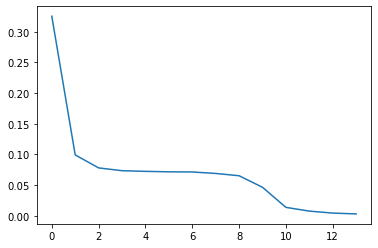

In [ ]:
australiafrogs_scaler_pca = StandardScaler().fit(Australia_frogweather_model[X_var])
Pca_australiafrogs = PCA ()
Pca_australiafrogs.fit(australiafrogs_scaler_pca.transform(Australia_frogweather_model[X_var]))
plt.plot(Pca_australiafrogs.explained_variance_ratio_);

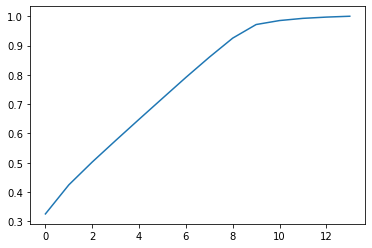

In [ ]:
plt.plot(np.cumsum(Pca_australiafrogs.explained_variance_ratio_));

Método do cotovelo sugere: 8 Componentes


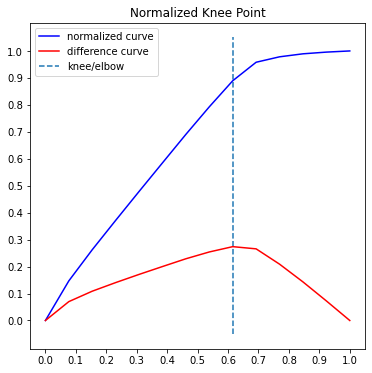

In [ ]:
knee_fit = KneeLocator(
    range(
        len(Pca_australiafrogs.explained_variance_ratio_)
    ),  # vetor com número dos componentes de 0 à 12
    np.cumsum(
        Pca_australiafrogs.explained_variance_ratio_
    ),  # soma acumulada da variância explicada por cada componente
)
print(f"Método do cotovelo sugere: {knee_fit.knee} Componentes")
knee_fit.plot_knee_normalized()

In [ ]:
Pca_australiafrogs = PCA(n_components=knee_fit.knee)
pca_australiafrogs = Pca_australiafrogs.fit_transform(
    australiafrogs_scaler_pca.transform(Australia_frogweather_model[X_var])
)  # SEMPRE NORMALIZAR DADOS ANTES DE PCA
tb_pca_australiafrogs = pd.DataFrame(
    pca_australiafrogs, columns=["PC" + str(i) for i in range(knee_fit.knee)]
)

In [ ]:
australiafrogs_scaler_LRpca = StandardScaler().fit(pca_australiafrogs)
australiafrogs_LRpca = LogisticRegression()
australiafrogs_LRpca.fit(australiafrogs_scaler_LRpca.transform(pca_australiafrogs), Australia_frogweather_model[y_var])

LogisticRegression()

In [ ]:
Australia_frogweather_model['pred_LRpca'] =  australiafrogs_LRpca.predict(australiafrogs_scaler_LRpca.transform(pca_australiafrogs))
print(f"Precisão: {precision_score(Australia_frogweather_model[y_var], Australia_frogweather_model['pred_LRpca'], average = 'weighted')}")
print(f"Recall: {recall_score(Australia_frogweather_model[y_var], Australia_frogweather_model['pred_LRpca'], average = 'weighted')}")
print(f"F1-Score: {f1_score(Australia_frogweather_model[y_var], Australia_frogweather_model['pred_LRpca'], average = 'weighted')}")

Precisão: 0.7665533344779843
Recall: 0.761309081073771
F1-Score: 0.7601281659104246


In [ ]:
australiafrogs_scaler_KNNpca = StandardScaler().fit(pca_australiafrogs)
australiafrogs_KNNpca = KNeighborsClassifier(n_neighbors=1)
australiafrogs_KNNpca.fit(australiafrogs_scaler_KNNpca.transform(pca_australiafrogs), Australia_frogweather_model[y_var])

KNeighborsClassifier(n_neighbors=1)

In [ ]:
Australia_frogweather_model['pred_KNNpca'] =  australiafrogs_KNNpca.predict(australiafrogs_scaler_KNNpca.transform(pca_australiafrogs))
print(f"Precisão: {precision_score(Australia_frogweather_model[y_var], Australia_frogweather_model['pred_KNNpca'], average = 'weighted')}")
print(f"Recall: {recall_score(Australia_frogweather_model[y_var], Australia_frogweather_model['pred_KNNpca'], average = 'weighted')}")
print(f"F1-Score: {f1_score(Australia_frogweather_model[y_var], Australia_frogweather_model['pred_KNNpca'], average = 'weighted')}")

Precisão: 0.88050923383726
Recall: 0.8600123214701617
F1-Score: 0.8581022669974706
